# Resolution of the system

In this code we will try to solve the problem of going from the state $T_-(1,1)$ to the state $S(1,1)$, with the minimum psssible population of the double ocupation state $S(0,2)$. The model of the system will be a effective 2-level Hamiltonian like

$$
H_0(\varepsilon)=\left(\begin{array}{cc}
\Delta(\varepsilon) & \lambda \\
\lambda & -\Delta(\varepsilon)
\end{array}\right)
$$

where $\Delta(\epsilon)= [-E_T-E_S(\varepsilon)]/2$, $E_T=g\mu_BB$ and $E_S(\varepsilon)=[u+\varepsilon-\sqrt{8\tau^2+(u+\varepsilon)^2}]/2$. The parameters that we will use are:

$$
\begin{split}
g&=1.35\\
B&=0.015 \; T\\
\tau&=0.25 \; \mu eV\\
\lambda&=0.1 \, \mu eV
\end{split}
$$

To work we some nice numbers the units of energy will be $\mu eV$ and the units of time $ns$.

In [3]:
#Libreries that we will use
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint, quad
from scipy.interpolate import interp1d
from IPython.display import Image

In [4]:
hbar=6.582*10**(-1) # Hbar (ueV*ns)
g=1.35# g-factor fo the GaAs
muB=57.883 # Bohr magneton (ueV/T)
B=0.015 # Magnetic field applied (T)
ET = g * muB* B # Zeeman spliting (ueV)
l = 0.1 # Spin-flip tunneling (ueV)
tau = 0.25 # Sping-conserving (ueV)
u = 2000  #Intradot interaction (ueV)

The energy spectrum of or system is shown in the following figure. The parameters used to obtain this plot are the same as the given above.
![title](img/Energy_Spectrum.png)

We will go from -4 to 4 in this graph. The value obtained for $\tilde{c}=3.26 \; ns$, the adiabaticity parameter $c=\tilde{c}/t_f\ll 1$, in our case the times that we will use are  $t_F \sim 15 \; ns$ obtaining $c\sim 0.2$. To compute this value we have made use of

$$
\tilde{c}=ct_F=\pm\hbar\int^{\Delta(t_f)}_{\Delta(0)}\dfrac{d \Delta}{\left|\dfrac{E_1-E_2}{\langle \phi_1| \partial _{\Delta}\phi_2\rangle}\right|}
$$

where the states are

$$
\begin{array}{cc}
|\phi_1\rangle=\left(\begin{array}{c}\cos(\theta/2) \\ \sin(\theta/2)\end{array}\right) & 
|\phi_2\rangle=\left(\begin{array}{c}\sin(\theta/2) \\ -\cos(\theta/2)\end{array}\right)
\end{array}
$$

$\tan(\theta/2)=[-\Delta+\sqrt{\Delta^2+\lambda^2}]/\lambda$ and $E_1-E_2=2\sqrt{\Delta^2+\lambda^2}$. The result obtained is finally

$$
\left|\dfrac{E_1-E_2}{\langle \phi_1|\partial_{\Delta}\phi_2\rangle}\right|=4\left|\dfrac{(\lambda^2+\Delta^2)^{1.5}}{\lambda}\right|
$$

In [5]:
Es = lambda eps: (u + eps - np.sqrt(8 * tau ** 2 + (u + eps) ** 2)) / 2 # Energy of the hibrid singlet state (ueV)
Delta = lambda eps: -(ET+Es(eps)) / 2 # Refactor of the energy level in the effective Hamiltonan (ueV)

eps0 = -4*np.abs(ET)-u # Bias energy at the beggining of the procedure (ueV)
epstf = 4*np.abs(ET)-u # Bias energy at the end of the procedure (ueV)
c1=hbar*np.abs(quad(lambda delta: l / np.abs(l ** 2 + delta ** 2) ** 1.5 / 4,Delta(eps0),Delta(epstf))[0]) # Rescaling of the adiabaticity parameter (ns)
print(c1) # Print the value obtained for the rescaling of the adiabaticy parameter

3.2638680446119364


Now we have to solve the EDO that give us the dependence of the bias in terms of the time, this is

$$
\dfrac{d\Delta}{ds}=\pm\dfrac{\tilde{c}}{\hbar}\left|\dfrac{E_1-E_2}{\langle \phi_1|\partial_{\Delta}\phi_2\rangle}\right|
$$

between $s=0$ and $s=1$.

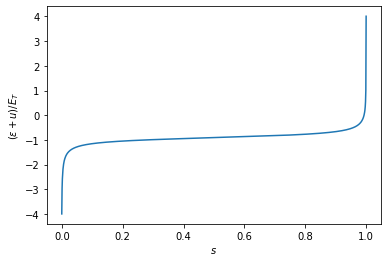

In [6]:
def model(y, t): # EDO to be solved
    return -c1/hbar*4*np.abs(y ** 2 + l ** 2) ** 1.5 /l # The sign has been choosen to get the right values of the bias

nt = 1000 # Numer of time steps
s = np.linspace(0, 1, nt, endpoint=True) # Rescaled time parameter s=t/tF
delta_sol = odeint(model, Delta(eps0), s)[:, 0]  # Solve numerically the values of the rescaling energy in terms of s
epsilon_sol = -2 * delta_sol - ET + 2 * tau ** 2 / (2 * delta_sol + ET) - u # Value for the bias in terms of s (this expression have being obtained inverting the eq. for Delta)
plt.plot(s, (epsilon_sol+u)/np.abs(ET)) # Plot for the rescaled bias
plt.xlabel(r'$s$')
plt.ylabel(r'$(\varepsilon+u)/E_T$');

c_eps=-(u+epsilon_sol+np.sqrt(8*tau**2+(u+epsilon_sol)**2))/(2*np.sqrt(2)*tau) #Hibrid single factor without normalization
c_eps=c_eps/np.sqrt(c_eps**2+1) #Hibrid single factor with normalization

The EDO's that we have to solve in order to obtain the dynamic of the system is given in terms of the density matrix

$$
\dfrac{d \rho(t)}{d t}=-\dfrac{i}{\hbar}\left[H(t),\rho(t)\right]
$$

In [7]:
def hamiltonian_ext(t,fEps): # Definition of the Hamiltonian of the system in terms of the time
    H=np.zeros([3,3],dtype=complex)
    epsilon=fEps(t)
    
    c_eps_temp=-(u+epsilon+np.sqrt(8*tau**2+(u+epsilon)**2))/(2*np.sqrt(2)*tau)
    c_eps_temp=c_eps_temp/np.sqrt(c_eps_temp**2+1)
    
    c_eps_temp_prime=(-u-epsilon+np.sqrt(8*tau**2+(u+epsilon)**2))/(2*np.sqrt(2)*tau)
    c_eps_temp_prime=c_eps_temp_prime/np.sqrt(c_eps_temp_prime**2+1)
    
    l_time=l*np.sqrt(1-c_eps_temp**2)
    l_prime_time=l*np.sqrt(1-c_eps_temp_prime**2)
    
    Es=(u+epsilon-np.sqrt(8*tau**2+(u+epsilon)**2))/2
    Es_prime=(u+epsilon+np.sqrt(8*tau**2+(u+epsilon)**2))/2
    
    H[0,:]=[fDelta(t),l_time,l_prime_time]
    H[1,:]=[l_time,Es,0]
    H[2,:]=[l_prime_time,0,Es_prime]
    return H

def hamiltonian(t,fEps):
    H=np.zeros([2,2],dtype=complex)
    
    epsilon=fEps(t)
    
    c_eps_temp=-(u+epsilon+np.sqrt(8*tau**2+(u+epsilon)**2))/(2*np.sqrt(2)*tau)
    c_eps_temp=c_eps_temp/np.sqrt(c_eps_temp**2+1)
    
    l_time=l*np.sqrt(1-c_eps_temp**2)
    
    H[0,:]=[fDelta(t),l_time]
    H[1,:]=[l_time,-fDelta(t)]
    return H

def density_matrix(t,y,dim,fEps): # Definition of the density matrix equation for the evolution
    rho=np.reshape(y,[dim,dim]) # The density matrix is given as an array, reshape to form a matrix
    if dim==2:
        H=hamiltonian(t,fEps) # Obtain the familtonian at the given time
    elif dim==3:
        H=hamiltonian_ext(t,fEps) # Obtain the familtonian at the given time
    drhodt=np.matmul(H,rho)-np.matmul(rho,H) # Compute the commutator of the density matrix and the Hamiltonian
    return(-1j*drhodt.flatten()/hbar) #Compute the right-hand side of the EDO to be solved

In [8]:
dim=2
density0=np.zeros([dim,dim],dtype=complex) #Initialize the variable to save the density matrix
density0[0,0]=1 # Initially the only state populated is the triplet (in our basis the first state)

n=100 #Number of different final times for the procedure
tf=np.linspace(0.1,30,n) # Array of final times (ns)
Prob=np.zeros([dim,n,nt]) # Variable to save the population for each state (state, final_time, evolution)

for i in range (0,n):  #Iterate to solve of the dynamics for each final time
    t=np.linspace(0,tf[i],nt) # Array for the time (ns)
    fDelta = interp1d(t, delta_sol, kind='cubic', fill_value="extrapolate") # Interpolate the values obtained for Delta
    fEps = interp1d(t, epsilon_sol, kind='cubic', fill_value="extrapolate") # Interpolate the values obtained for epsilon
    sol= solve_ivp(density_matrix,(t[0],t[-1]), density0.flatten(),t_eval=t,args=[dim,fEps]) # Solve the dynamic
    solution=sol.y # Extract the solution for the density matric in terms of the time
    density=np.reshape(solution,[dim,dim,nt]) # Reshape the solution to obtain a proper matrix (dim,dim,time)
    for j in range (0,dim):
        Prob[j,i,:]=np.abs(density[j,j,:]) # Probability to populate the states

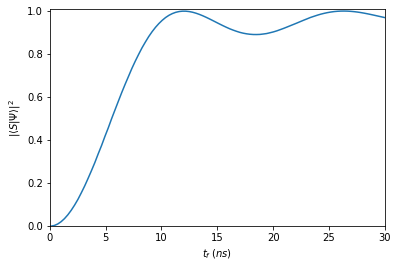

In [9]:
fig1=plt.figure() #Plot the fidelty to populate the hibrid singlet state
ax1=fig1.add_subplot(1,1,1)
ax1.plot(tf,Prob[1,:,-1])
ax1.set_xlim(t[0],t[-1])
ax1.set_ylim(0,1.01);
ax1.set_xlabel(r'$t_f\; (ns)$')
ax1.set_ylabel(r'$|\langle S|\Psi\rangle|^2$');

In [10]:
index=np.where(Prob[1,:,-1]==np.max(Prob[1,:,-1]))[0][0] # Index where the maximun fidelity have been reached
print(tf[index]) # Time for the maximun fidelity (ns)
print(Prob[1,:,-1][index])

26.37575757575758
0.9993436283283024


Now we what to check how many each singlet state have being populated. For this we know that the hibrid state is, without the normalization factor

$$
|S\rangle=-\dfrac{u+\varepsilon+\sqrt{8\tau^2+(u+\varepsilon)^2}}{2\sqrt{2}\tau}|S(1,1)\rangle+|S(0,2)\rangle 
$$

This result have being obtained from Mathematica

In [11]:
prob_T=Prob[0,index,:] # Probability to populate the triplet state in terms of time for a given final time
prob_S_11=Prob[1,index,:]*np.abs(c_eps)**2 # Probability to populate the single ocupation singlet state in terms of time for a given final time
prob_S_02=Prob[1,index,:]*(1-np.abs(c_eps)**2) # Probability to populate the double ocupation singlet state in terms of time for a given final time
t=np.linspace(0,tf[index],nt) # Array of time for a given final time (ns)

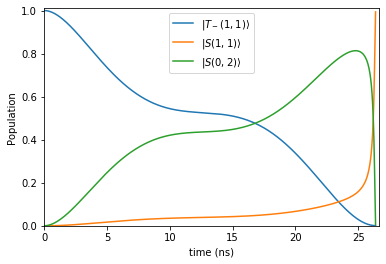

In [12]:
fig2=plt.figure() #Plot the population for each state in terms of time
ax2=fig2.add_subplot(1,1,1)
ax2.plot(t,prob_T,label=r'$|T_-(1,1)\rangle$')
ax2.plot(t,prob_S_11,label=r'$|S(1,1)\rangle$')
ax2.plot(t,prob_S_02,label=r'$|S(0,2)\rangle$')
ax2.legend()
ax2.set_xlabel('time (ns)')
ax2.set_ylabel('Population')
ax2.set_xlim([0,tf[index]*1.01])
ax2.set_ylim([0,1.01]);

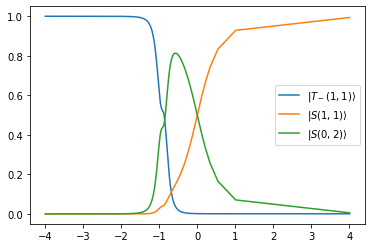

In [13]:
fig3=plt.figure()
ax3=fig3.add_subplot(1,1,1)
ax3.plot((epsilon_sol+u)/ET,prob_T,label=r'$|T_-(1,1)\rangle$')
ax3.plot((epsilon_sol+u)/ET,prob_S_11,label=r'$|S(1,1)\rangle$')
ax3.plot((epsilon_sol+u)/ET,prob_S_02,label=r'$|S(0,2)\rangle$')
ax3.legend()

# Plots to be save
From this point all the code is to generate good looking graphs to be printed in the .PDF

In [ ]:
line_width=2.5
legend_size=20
label_size=20
tick_labe_size=15

fig1=plt.figure(figsize=(7.68,4)) #Plot the fidelty to populate the hibrid singlet state
ax1=fig1.add_subplot(1,1,1)
ax1.plot(tf,Prob[1,:,-1],linewidth=line_width)
ax1.set_xlim(tf[0],tf[-1])
ax1.set_ylim(0,1.05);
ax1.set_xlabel(r'$t_f\; (ns)$',fontsize=label_size)
ax1.set_ylabel('F',fontsize=label_size)
ax1.tick_params(axis='both', which='major', labelsize=tick_labe_size,direction='in',length=6.5)


dic='D:/OneDrive - Universidad Autonoma de Madrid/Universidad/Dropbox/Trabajo Yue-David/Notas David/LaTeX/images'
arch='fidelity_1'
img_format='png'
fig1.savefig(dic+'/' +arch+'.'+img_format,format=img_format,bbox_inches="tight",dpi=300)

In [ ]:
line_width=2.5
legend_size=17
label_size=20
tick_labe_size=15

fig2=plt.figure(figsize=(7.68,5.76)) #Plot the population for each state in terms of time
ax2=fig2.add_subplot(1,1,1)
ax2.plot(t,prob_T,label=r'$|T_-(1,1)\rangle$',linewidth=line_width)
ax2.plot(t,prob_S_11,label=r'$|S(1,1)\rangle$',linewidth=line_width)
ax2.plot(t,prob_S_02,label=r'$|S(0,2)\rangle$',linewidth=line_width)
ax2.legend(fontsize=legend_size)
ax2.set_xlabel('time (ns)',fontsize=label_size)
ax2.set_ylabel('Population',fontsize=label_size)
ax2.set_xlim([0,tf[index]*1.01])
ax2.set_ylim([0,1.01])
ax2.tick_params(axis='both', which='major', labelsize=tick_labe_size,direction='in',length=6.5)

dic='D:/OneDrive - Universidad Autonoma de Madrid/Universidad/Dropbox/Trabajo Yue-David/Notas David/LaTeX/images'
arch='population_1'
img_format='png'
fig2.savefig(dic+'/' +arch+'.'+img_format,format=img_format,bbox_inches="tight",dpi=300)

In [ ]:
line_width=2.5
legend_size=17
label_size=20
tick_labe_size=15

fig3=plt.figure(figsize=(7.68,5.76))
ax3=fig3.add_subplot(1,1,1)
ax3.plot(s, (epsilon_sol+u)/np.abs(ET)) # Plot for the rescaled bias
plt.xlabel(r'$s$')
plt.ylabel(r'$(\varepsilon+u)/E_T$');

In [ ]:
line_width=2.5
legend_size=17
label_size=20
tick_labe_size=15

fig3=plt.figure(figsize=(7.68,5.76))
ax3=fig3.add_subplot(1,1,1)
ax3.plot(s, (epsilon_sol+u)/np.abs(ET)) # Plot for the rescaled bias
plt.xlabel(r'$s$')
plt.ylabel(r'$(\varepsilon+u)/E_T$');

In [ ]:
line_width=2.5
legend_size=17
label_size=20
tick_labe_size=15

fig2=plt.figure(figsize=(7.68,5.76)) #Plot the population for each state in terms of time
ax2=fig2.add_subplot(1,1,1)
ax2.plot(t,prob_T,label=r'$|T_-(1,1)\rangle$',linewidth=line_width)
ax2.plot(t,prob_S_11,label=r'$|S(1,1)\rangle$',linewidth=line_width)
ax2.plot(t,prob_S_02,label=r'$|S(0,2)\rangle$',linewidth=line_width)
ax2.legend(fontsize=legend_size)
ax2.set_xlabel('time (ns)',fontsize=label_size)
ax2.set_ylabel('Population',fontsize=label_size)
ax2.set_xlim([0,tf[index]*1.01])
ax2.set_ylim([0,1.01])
ax2.tick_params(axis='both', which='major', labelsize=tick_labe_size,direction='in',length=6.5)

dic='D:/OneDrive - Universidad Autonoma de Madrid/Universidad/Dropbox/Trabajo Yue-David/Notas David/LaTeX/images'
arch='population_1'
img_format='png'
fig2.savefig(dic+'/' +arch+'.'+img_format,format=img_format,bbox_inches="tight",dpi=300)

In [ ]:
line_width=2.5
legend_size=17
label_size=20
tick_labe_size=15

fig3=plt.figure(figsize=(7.68,5.76))
ax3=fig3.add_subplot(1,1,1)
ax3.plot(s, (epsilon_sol+u)/np.abs(ET)) # Plot for the rescaled bias
plt.xlabel(r'$s$')
plt.ylabel(r'$(\varepsilon+u)/E_T$');

In [ ]:
line_width=2.5
legend_size=17
label_size=20
tick_labe_size=15

fig3=plt.figure(figsize=(7.68,5.76))
ax3=fig3.add_subplot(1,1,1)
ax3.plot(s, (epsilon_sol+u)/np.abs(ET)) # Plot for the rescaled bias
plt.xlabel(r'$s$')
plt.ylabel(r'$(\varepsilon+u)/E_T$');

In [ ]:
line_width=2.5
legend_size=17
label_size=20
tick_labe_size=15

fig2=plt.figure(figsize=(7.68,5.76)) #Plot the population for each state in terms of time
ax2=fig2.add_subplot(1,1,1)
ax2.plot(t,prob_T,label=r'$|T_-(1,1)\rangle$',linewidth=line_width)
ax2.plot(t,prob_S_11,label=r'$|S(1,1)\rangle$',linewidth=line_width)
ax2.plot(t,prob_S_02,label=r'$|S(0,2)\rangle$',linewidth=line_width)
ax2.legend(fontsize=legend_size)
ax2.set_xlabel('time (ns)',fontsize=label_size)
ax2.set_ylabel('Population',fontsize=label_size)
ax2.set_xlim([0,tf[index]*1.01])
ax2.set_ylim([0,1.01])
ax2.tick_params(axis='both', which='major', labelsize=tick_labe_size,direction='in',length=6.5)

dic='D:/OneDrive - Universidad Autonoma de Madrid/Universidad/Dropbox/Trabajo Yue-David/Notas David/LaTeX/images'
arch='population_1'
img_format='png'
fig2.savefig(dic+'/' +arch+'.'+img_format,format=img_format,bbox_inches="tight",dpi=300)

In [ ]:
line_width=2.5
legend_size=17
label_size=20
tick_labe_size=15

fig3=plt.figure(figsize=(7.68,5.76))
ax3=fig3.add_subplot(1,1,1)
ax3.plot(s, (epsilon_sol+u)/np.abs(ET)) # Plot for the rescaled bias
plt.xlabel(r'$s$')
plt.ylabel(r'$(\varepsilon+u)/E_T$');

In [ ]:
line_width=2.5
legend_size=17
label_size=20
tick_labe_size=15

fig3=plt.figure(figsize=(7.68,5.76))
ax3=fig3.add_subplot(1,1,1)
ax3.plot(s, (epsilon_sol+u)/np.abs(ET)) # Plot for the rescaled bias
plt.xlabel(r'$s$')
plt.ylabel(r'$(\varepsilon+u)/E_T$');

In [ ]:
line_width=2.5
legend_size=17
label_size=20
tick_labe_size=15

fig2=plt.figure(figsize=(7.68,5.76)) #Plot the population for each state in terms of time
ax2=fig2.add_subplot(1,1,1)
ax2.plot(t,prob_T,label=r'$|T_-(1,1)\rangle$',linewidth=line_width)
ax2.plot(t,prob_S_11,label=r'$|S(1,1)\rangle$',linewidth=line_width)
ax2.plot(t,prob_S_02,label=r'$|S(0,2)\rangle$',linewidth=line_width)
ax2.legend(fontsize=legend_size)
ax2.set_xlabel('time (ns)',fontsize=label_size)
ax2.set_ylabel('Population',fontsize=label_size)
ax2.set_xlim([0,tf[index]*1.01])
ax2.set_ylim([0,1.01])
ax2.tick_params(axis='both', which='major', labelsize=tick_labe_size,direction='in',length=6.5)

dic='D:/OneDrive - Universidad Autonoma de Madrid/Universidad/Dropbox/Trabajo Yue-David/Notas David/LaTeX/images'
arch='population_1'
img_format='png'
fig2.savefig(dic+'/' +arch+'.'+img_format,format=img_format,bbox_inches="tight",dpi=300)

In [ ]:
line_width=2.5
legend_size=17
label_size=20
tick_labe_size=15

fig3=plt.figure(figsize=(7.68,5.76))
ax3=fig3.add_subplot(1,1,1)
ax3.plot(s, (epsilon_sol+u)/np.abs(ET)) # Plot for the rescaled bias
plt.xlabel(r'$s$')
plt.ylabel(r'$(\varepsilon+u)/E_T$');

In [ ]:
line_width=2.5
legend_size=17
label_size=20
tick_labe_size=15

fig3=plt.figure(figsize=(7.68,5.76))
ax3=fig3.add_subplot(1,1,1)
ax3.plot(s, (epsilon_sol+u)/np.abs(ET)) # Plot for the rescaled bias
plt.xlabel(r'$s$')
plt.ylabel(r'$(\varepsilon+u)/E_T$');

In [ ]:
line_width=2.5
legend_size=17
label_size=20
tick_labe_size=15

fig2=plt.figure(figsize=(7.68,5.76)) #Plot the population for each state in terms of time
ax2=fig2.add_subplot(1,1,1)
ax2.plot(t,prob_T,label=r'$|T_-(1,1)\rangle$',linewidth=line_width)
ax2.plot(t,prob_S_11,label=r'$|S(1,1)\rangle$',linewidth=line_width)
ax2.plot(t,prob_S_02,label=r'$|S(0,2)\rangle$',linewidth=line_width)
ax2.legend(fontsize=legend_size)
ax2.set_xlabel('time (ns)',fontsize=label_size)
ax2.set_ylabel('Population',fontsize=label_size)
ax2.set_xlim([0,tf[index]*1.01])
ax2.set_ylim([0,1.01])
ax2.tick_params(axis='both', which='major', labelsize=tick_labe_size,direction='in',length=6.5)

dic='D:/OneDrive - Universidad Autonoma de Madrid/Universidad/Dropbox/Trabajo Yue-David/Notas David/LaTeX/images'
arch='population_1'
img_format='png'
fig2.savefig(dic+'/' +arch+'.'+img_format,format=img_format,bbox_inches="tight",dpi=300)

In [ ]:
line_width=2.5
legend_size=17
label_size=20
tick_labe_size=15

fig3=plt.figure(figsize=(7.68,5.76))
ax3=fig3.add_subplot(1,1,1)
ax3.plot(s, (epsilon_sol+u)/np.abs(ET)) # Plot for the rescaled bias
plt.xlabel(r'$s$')
plt.ylabel(r'$(\varepsilon+u)/E_T$');